<a href="https://colab.research.google.com/github/OBB-2199/EscapeEarth/blob/main/Interns/Olivia/TICID_356632361.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## mount google drive to access files

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
## typical imports
%matplotlib inline
!pip install lightkurve==1.9.0 #b/c non-standard library & we want a specific version
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 492 kB 4.3 MB/s 
     |████████████████████████████████| 4.4 MB 33.9 MB/s 
     |████████████████████████████████| 98 kB 6.7 MB/s 
     |████████████████████████████████| 802 kB 56.1 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 3.0 MB 45.6 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=b005bea2f80e1cfb2250149433d7251285107f39f3ac4d10187cedd1a6b6c6bf
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3864 sha256=5c6e1f753266322b2ec0591aaa1db03e97bb4b4f128f75c92e9bdaa3c23b00d1
  Stored in directory: /root/.cache/pip/wheels/49/b4/2d/0081759ae1833bd694024801f7aacddcda8a687e8d5fbaeebd
  Created wheel for oktopus: filename=oktopus-0.1.2-py3-none-any.whl size=12778 sha256=f54df23e2f22d47391c324633f7cff02aff536e505bfbdcca74b4ff

In [3]:
#find available data
search_result = lk.search_lightcurvefile('TIC  356632361')
search_result

#,observation,target_name,productFilename,distance
0,TESS Sector 14,356632361,tess2019198215352-s0014-0000000356632361-0150-s_lc.fits,0.0
1,TESS Sector 15,356632361,tess2019226182529-s0015-0000000356632361-0151-s_lc.fits,0.0
2,TESS Sector 16,356632361,tess2019253231442-s0016-0000000356632361-0152-s_lc.fits,0.0
3,TESS Sector 21,356632361,tess2020020091053-s0021-0000000356632361-0167-s_lc.fits,0.0
4,TESS Sector 22,356632361,tess2020049080258-s0022-0000000356632361-0174-s_lc.fits,0.0
5,TESS Sector 23,356632361,tess2020078014623-s0023-0000000356632361-0177-s_lc.fits,0.0
6,TESS Sector 24,356632361,tess2020106103520-s0024-0000000356632361-0180-s_lc.fits,0.0


In [4]:
#download all data available
lc_files = search_result.download_all()
lc_files

LightCurveFileCollection of 7 objects:
	TIC 356632361 (7 TessLightCurveFiles) Sectors: 14,15,16,21,22,23,24

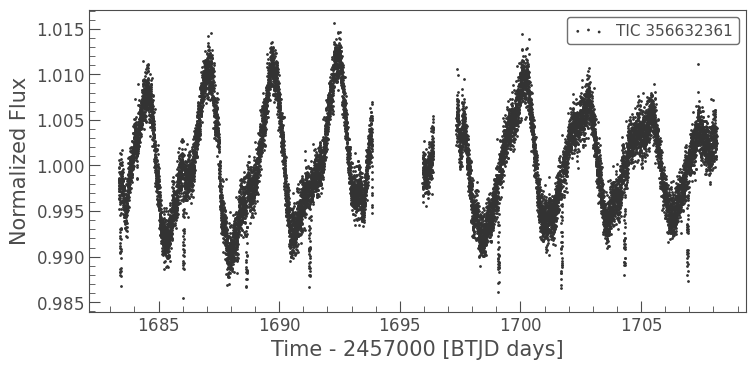

In [5]:
#clean & visualize data
%matplotlib inline

lc = lc_files[0].PDCSAP_FLUX.normalize() #select first file, select detrended flux, normalize #NOTE: if only one file available try removing [0] b/c it will cause an error
lcflat=lc.flatten() #flatten rotational modulations
lc_gtg = lcflat.remove_nans() #remove nans from data gaps
#NOTE: we skipped the remove outliers step to avoid cutting off transit bottoms 

lc.scatter(); #plot light curve before flattening (ie theres still rotational modulations in the data)

In [6]:
#functions from our LCAnalysis

def periods(N=1000):
    period=np.logspace(-0.523, 1.43, N, endpoint=True)
    return period

def duration_grid(N=3):
    duration=np.linspace(.01, 0.298, N)
    return duration
    
def BLS(periodgrid,lightcurve,flat_time,durationgrid):
    from astropy.timeseries import BoxLeastSquares

    '''
    Purppose
    ------------------
    A Box Least Squares function to print out the compute stats of the periodogram.
    Parameters
    -------------------
    period grid            - describes how often the transit is happening (arrays different value)
    duration grid          - describes the width of the transit (array of different values)
    lightcurve             - lightkurve class object
    Returns
    list of stats in the following order: period, duration, transit-time, power, depth
    ------------------
    Calculate several statistics of a candidate transit.
    '''
    #assigning parameters to variables
    period = periodgrid
    duration = durationgrid
    lc = lightcurve

    t = flat_time #time
    y = lc.flux #flux

    #dy is the uncertianty
    model = BoxLeastSquares(t, y, dy= lc.flux_err)
    periodogram = model.power(period,duration)
    max_power = np.argmax(periodogram.power)

    #calculates the max stats w/in the transit
    stats = [periodogram.period[max_power],
            periodogram.duration[max_power],
            periodogram.transit_time[max_power],
            max_power,
            periodogram.depth[max_power],
            periodogram.period,periodogram.power]

    #stats is the one peak, periodogram is the array
    return stats




In [10]:
#run BLS

##to use defaults
# pg = periods()
# dg = duration_grid()

## OR customize period & duration grids
pg = np.linspace(2,3, 10000) # change 1st & 2nd values to change startpoint & endpoint of list of periods to check
dg = np.linspace(.03,.04, 10000) # change same as for period grid

#run BLS
bls_output = BLS(pg, lc_gtg, lc_gtg.time, dg)
bls_output[0:5] #period, duration, transit_time, power, depth  <---meaning of order of output values

[2.6112611261126113, 0.033, 1683.4234777189629, 6112, 0.005497541222489243]

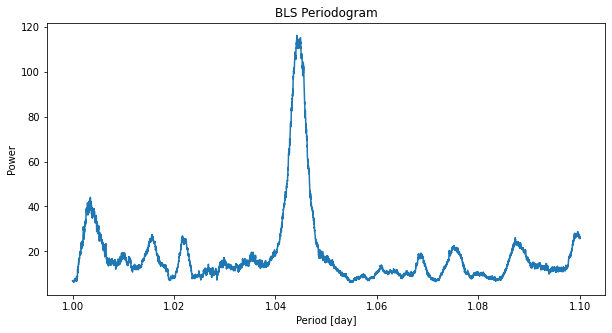

In [8]:
#plot the periodogram

plt.figure(figsize=(10,5))
plt.plot(bls_output[5],bls_output[6]) #x-axis = periods checked, y-axis = strength of model fit at period checked
plt.xlabel('Period [day]')
plt.ylabel('Power') 
plt.title('BLS Periodogram');
plt.savefig('/content/gdrive/My Drive/EE-notebooks-OLIVIA/SummerResearch/BLS Periodogram 356632361 2', dpi=200)

#highest peak is the best fit orbital period, any other peaks should appear at multiples of the best peak OR could be more planets!

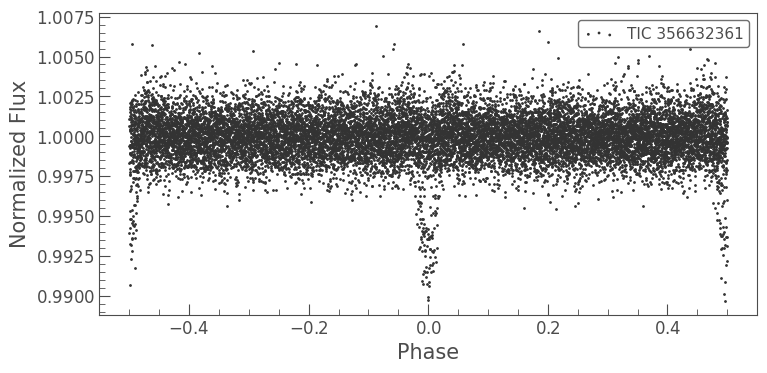

In [9]:
#plot folded light curve

#fold lc
lcfold = lc_gtg.fold(bls_output[0],t0=bls_output[2]) #inputs are best fit model's (period value, transit_time) 
#the transit time helps center the transit in the folded plot

lcfold.scatter() #actual plot
